Fully connected layers are typically followed by a sigmoid activation function. Add a sigmoid activation function after each linear layer and remove the ReLU function for the linear layers (Architecture 2).  

Run the code.  

Generate the train and validation loss curves.  

Evaluate the model by producing the confusion matrix and other evaluation metrics.  

In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
import yaml
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from torchvision import transforms
from torchvision.io import read_image

In [ ]:
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/CNN_config.yaml
!unzip -q CIFAR-10.zip -d .

--2024-12-21 08:01:57--  https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip [following]
--2024-12-21 08:01:57--  https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57166560 (55M) [application/zip]
Saving to: ‘CIFAR-10.zip’

CIFAR-10.zip        100%[===================>]  54.52M   349MB/s    in 0.2s    

2024-12-21 08:01:59 (349 MB/s) - ‘CIFAR-10.zip’ saved [57166560/57166560]

--2024-12

In [ ]:
file = open("CNN_config.yaml")
config = yaml.safe_load(file)
file.close()
print(config)

{'data_params': {'data_path': 'CIFAR-10/', 'train_ratio': 0.8, 'batch_size': 64}, 'model_params': {'num_classes': 10, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'gamma': 0.1, 'step_size': 5, 'num_epochs': 10}}


In [ ]:
class CIFAR10(torch.utils.data.Dataset):
    """The CIFAR10 dataset"""

    def __init__(self, root, transform=None, target_transform=None) -> None:
        """
        Initialize the CIFAR10 dataset

        :param root: The root directory of the dataset
        :type root: str
        :param transform: The transform to apply to the data
        :type transform: callable
        :param target_transform: The transform to apply to the target
        :type target_transform: callable

        :return: None
        :rtype: None
        """
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.targets = []

        self._load_data()

    def _load_data(self):
        """
        Load the data from the root directory

        :return: None
        :rtype: None
        """
        # Load the data
        classes = os.listdir(self.root)
        classes.sort()
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(self.root, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = read_image(image_path)
                self.data.append(image)
                self.targets.append(float(i))

    def __getitem__(self, index: int) -> tuple:
        """
        Get the item at the given index

        :param index: The index of the item
        :type index: int

        :return: The item at the given index
        :rtype: tuple
        """
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        """
        Get the length of the dataset

        :return: The length of the dataset
        :rtype: int
        """
        return len(self.data)

In [ ]:
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# you can transform the target too if you want (e.g. one hot encode)
target_transform = transforms.Lambda(
    lambda y: torch.tensor(y, dtype=torch.long))

In [ ]:
data_path = config["data_params"]["data_path"]
classes = os.listdir(data_path)
classes.sort()

dataset = CIFAR10(data_path, transform=transform,
                  target_transform=target_transform)

# dataset = ImageFolder(data_path, transform=transform,
#  target_transform=target_transform)

In [ ]:
train_size = config["data_params"]["train_ratio"]
test_size = (1 - train_size) / 2
val_size = test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Train size: 48001
Test size: 6000
Validation size: 5999


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

In [ ]:
class Cifar10CnnModel(nn.Module):
    """The CIFAR10 CNN model"""

    def __init__(self, output_size: int) -> None:
        """
        Initialize the CIFAR10 CNN model

        :param output_size: The number of output classes
        :type output_size: int
        """
        super().__init__()
        self.network = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64 x 16 x 16

            # Second Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128 x 8 x 8

            # Third Convolutional Block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 256 x 4 x 4

            # Flatten and Fully Connected Layers
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.Sigmoid(),          # Replaced ReLU with Sigmoid
            nn.Linear(1024, 512),
            nn.Sigmoid(),          # Replaced ReLU with Sigmoid
            nn.Linear(512, output_size)
            # Note: Typically, no activation here if using CrossEntropyLoss
        )
        self._initialize_weights_()

    def _initialize_weights_(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        :param x: Input tensor
        :type x: torch.Tensor
        :return: Output tensor
        :rtype: torch.Tensor
        """
        return self.network(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Cifar10CnnModel(
    config['model_params']['num_classes']
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["model_params"]["learning_rate"],
    # L2 regularization
    weight_decay=config["model_params"]["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config["model_params"]["step_size"],
    gamma=config["model_params"]["gamma"]
)

In [ ]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

In [ ]:
def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
    device: torch.device,
    num_epochs: int
) -> tuple:
    """
    Train the model

    :param model: The model to train
    :type model: torch.nn.Module
    :param train_loader: The training loader
    :type train_loader: torch.utils.data.DataLoader
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param optimizer: The optimizer
    :type optimizer: torch.optim.Optimizer
    :param scheduler: The learning rate scheduler
    :type scheduler: torch.optim.lr_scheduler.StepLR
    :param device: The device to use
    :type device: torch.device
    :param num_epochs: The number of epochs
    :type num_epochs: int

    :return: The trained model and the training history
    :rtype: tuple
    """
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)
        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=train_loss / (i + 1))

        train_loss /= len(train_loader)
        val_loss, val_acc, _ = validate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "history": history
            }
            torch.save(checkpoint, "checkpoint.pth")

        scheduler.step()

    return model, history

In [ ]:
model, history = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config["model_params"]["num_epochs"]
)

Epoch [1/10]
Train loss: 1.6304
Validation loss: 1.7089
Validation accuracy: 0.42%


Epoch [2/10]
Train loss: 1.1233
Validation loss: 1.0215
Validation accuracy: 0.63%


Epoch [3/10]
Train loss: 0.9085
Validation loss: 1.1136
Validation accuracy: 0.63%


Epoch [4/10]
Train loss: 0.8057
Validation loss: 0.8342
Validation accuracy: 0.71%


Epoch [5/10]
Train loss: 0.6879
Validation loss: 1.0487
Validation accuracy: 0.65%


Epoch [6/10]
Train loss: 0.5048
Validation loss: 0.7050
Validation accuracy: 0.76%


Epoch [7/10]
Train loss: 0.4519
Validation loss: 0.7008
Validation accuracy: 0.76%


Epoch [8/10]
Train loss: 0.4208
Validation loss: 0.6949
Validation accuracy: 0.77%


Epoch [9/10]
Train loss: 0.3943
Validation loss: 0.7040
Validation accuracy: 0.77%


Epoch [10/10]
Train loss: 0.3686
Validation loss: 0.7090
Validation accuracy: 0.77%


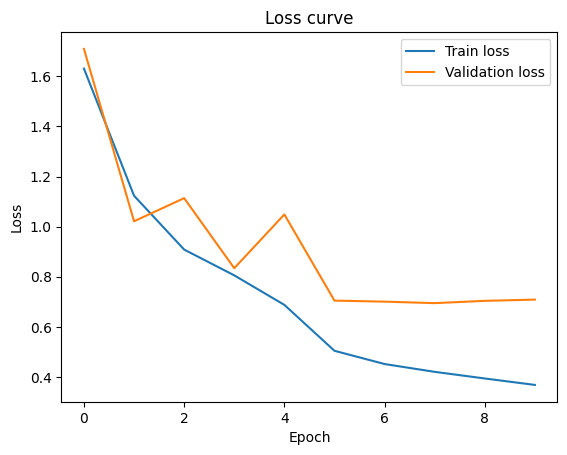

In [ ]:
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model"])

<ipython-input-22-7f9a5e566b90>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth")["model"])


<All keys matched successfully>

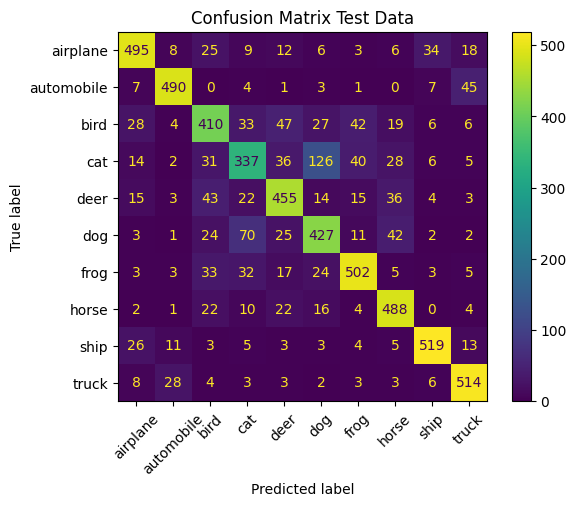




              precision    recall  f1-score   support

    airplane       0.82      0.80      0.81       616
  automobile       0.89      0.88      0.88       558
        bird       0.69      0.66      0.67       622
         cat       0.64      0.54      0.59       625
        deer       0.73      0.75      0.74       610
         dog       0.66      0.70      0.68       607
        frog       0.80      0.80      0.80       627
       horse       0.77      0.86      0.81       569
        ship       0.88      0.88      0.88       592
       truck       0.84      0.90      0.86       574

    accuracy                           0.77      6000
   macro avg       0.77      0.78      0.77      6000
weighted avg       0.77      0.77      0.77      6000



In [ ]:
_, _, y_pred = validate(model, test_loader, criterion, device)
y_test = [labels for _, labels in test_loader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

Add a convolution layer followed by a ReLU activation layer just before the flattening step (Architecture 3).  

Run the code.  

Generate the train and validation loss curves.  

Evaluate the model by producing the confusion matrix and other evaluation metrics.  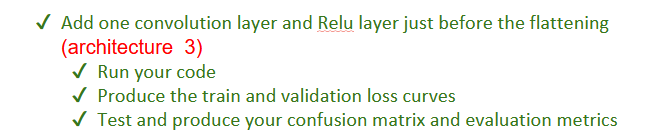

In [ ]:
class Cifar10CnnModel(nn.Module):
    """The CIFAR10 CNN model with an additional Conv and ReLU layer before Flatten"""

    def __init__(self, output_size: int) -> None:
        """
        Initialize the CIFAR10 CNN model

        :param output_size: The number of output classes
        :type output_size: int
        """
        super().__init__()
        self.network = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64 x 16 x 16

            # Second Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128 x 8 x 8

            # Third Convolutional Block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 256 x 4 x 4

            # **Additional Convolutional Layer**
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),  # Output: 512 x 4 x 4

            # Flattening Layer
            nn.Flatten(),

            # Fully Connected Layers
            nn.Linear(512 * 4 * 4, 1024),  # Updated input features
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
        self._initialize_weights_()

    def _initialize_weights_(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        :param x: The input data
        :type x: torch.Tensor

        :return: The output logits
        :rtype: torch.Tensor
        """
        return self.network(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Cifar10CnnModel(
    config['model_params']['num_classes']
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["model_params"]["learning_rate"],
    # L2 regularization
    weight_decay=config["model_params"]["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config["model_params"]["step_size"],
    gamma=config["model_params"]["gamma"]
)

In [ ]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

In [ ]:
def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
    device: torch.device,
    num_epochs: int
) -> tuple:
    """
    Train the model

    :param model: The model to train
    :type model: torch.nn.Module
    :param train_loader: The training loader
    :type train_loader: torch.utils.data.DataLoader
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param optimizer: The optimizer
    :type optimizer: torch.optim.Optimizer
    :param scheduler: The learning rate scheduler
    :type scheduler: torch.optim.lr_scheduler.StepLR
    :param device: The device to use
    :type device: torch.device
    :param num_epochs: The number of epochs
    :type num_epochs: int

    :return: The trained model and the training history
    :rtype: tuple
    """
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)
        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=train_loss / (i + 1))

        train_loss /= len(train_loader)
        val_loss, val_acc, _ = validate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "history": history
            }
            torch.save(checkpoint, "checkpoint.pth")

        scheduler.step()

    return model, history

In [ ]:
model, history = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config["model_params"]["num_epochs"]
)

Epoch [1/10]
Train loss: 1.5227
Validation loss: 1.1800
Validation accuracy: 0.58%


Epoch [2/10]
Train loss: 1.0294
Validation loss: 1.0511
Validation accuracy: 0.63%


Epoch [3/10]
Train loss: 0.8223
Validation loss: 0.9335
Validation accuracy: 0.68%


Epoch [4/10]
Train loss: 0.6910
Validation loss: 0.8219
Validation accuracy: 0.71%


Epoch [5/10]
Train loss: 0.6015
Validation loss: 0.7546
Validation accuracy: 0.75%


Epoch [6/10]
Train loss: 0.3504
Validation loss: 0.7208
Validation accuracy: 0.78%


Epoch [7/10]
Train loss: 0.2764
Validation loss: 0.7331
Validation accuracy: 0.78%


Epoch [8/10]
Train loss: 0.2242
Validation loss: 0.7958
Validation accuracy: 0.78%


Epoch [9/10]
Train loss: 0.1782
Validation loss: 0.8420
Validation accuracy: 0.78%


Epoch [10/10]
Train loss: 0.1349
Validation loss: 0.9323
Validation accuracy: 0.78%


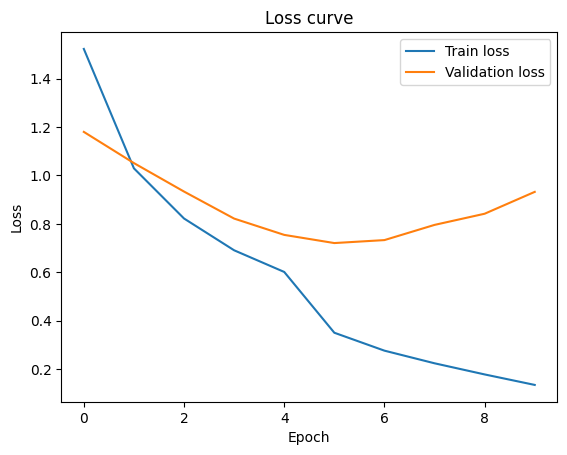

In [ ]:
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model"])

<ipython-input-30-7f9a5e566b90>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth")["model"])


<All keys matched successfully>

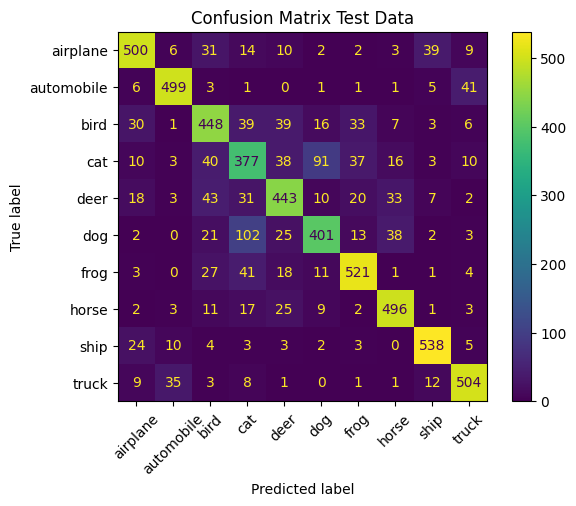




              precision    recall  f1-score   support

    airplane       0.83      0.81      0.82       616
  automobile       0.89      0.89      0.89       558
        bird       0.71      0.72      0.72       622
         cat       0.60      0.60      0.60       625
        deer       0.74      0.73      0.73       610
         dog       0.74      0.66      0.70       607
        frog       0.82      0.83      0.83       627
       horse       0.83      0.87      0.85       569
        ship       0.88      0.91      0.89       592
       truck       0.86      0.88      0.87       574

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



In [ ]:
_, _, y_pred = validate(model, test_loader, criterion, device)
y_test = [labels for _, labels in test_loader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

Add batch normalization layers to the first two fully connected (FC) layers, placing them just before the sigmoid activation function (Architecture 4).  

Apply batch normalization to each FC layer immediately before the sigmoid activation.  

Run the code.  

Generate the train and validation loss curves.  

Evaluate the model by producing the confusion matrix and other evaluation metrics.  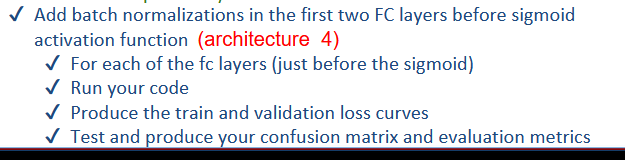

Replaced BatchNorm2d with GroupNorm

In [ ]:
import torch
import torch.nn as nn

class Cifar10CnnModel(nn.Module):
    """The CIFAR10 CNN model with additional convolutional and normalization layers."""

    def __init__(self, output_size: int) -> None:
        """
        Initialize the CIFAR10 CNN model with the specified architecture.

        :param output_size: The number of output classes.
        :type output_size: int
        """
        super().__init__()
        self.network = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),    # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(16, 64),   # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # Output: 64 x 16 x 16

            # Second Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, 128),  # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, 128),  # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # Output: 128 x 8 x 8

            # Third Convolutional Block with Additional Conv and ReLU (Architecture 3)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(64, 256),  # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(64, 256),  # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Added Conv Layer
            nn.GroupNorm(128, 512), # Replaced BatchNorm2d with GroupNorm
            nn.ReLU(),                                           # Added ReLU Layer
            nn.MaxPool2d(2, 2),  # Output: 512 x 4 x 4

            nn.Flatten(),

            # First Fully Connected Layer with Group Normalization (Architecture 4)
            nn.Linear(512 * 4 * 4, 1024),
            nn.GroupNorm(32, 1024),  # Replaced BatchNorm1d with GroupNorm
            nn.ReLU(),
            nn.Dropout(0.5),          # Added Dropout for regularization

            # Second Fully Connected Layer with Group Normalization (Architecture 4)
            nn.Linear(1024, 512),
            nn.GroupNorm(16, 512),   # Replaced BatchNorm1d with GroupNorm
            nn.ReLU(),
            nn.Dropout(0.5),          # Added Dropout for regularization

            # Output Layer
            nn.Linear(512, output_size)
        )
        self._initialize_weights_()

    def _initialize_weights_(self):
        """
        Initialize weights of the network using Xavier uniform initialization for
        linear and convolutional layers, and zero initialization for biases.
        """
        for layer in self.network:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        :param x: Input tensor.
        :type x: torch.Tensor

        :return: Output logits.
        :rtype: torch.Tensor
        """
        return self.network(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Cifar10CnnModel(
    config['model_params']['num_classes']
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["model_params"]["learning_rate"],
    # L2 regularization
    weight_decay=config["model_params"]["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config["model_params"]["step_size"],
    gamma=config["model_params"]["gamma"]
)

In [ ]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

In [ ]:
def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
    device: torch.device,
    num_epochs: int
) -> tuple:
    """
    Train the model

    :param model: The model to train
    :type model: torch.nn.Module
    :param train_loader: The training loader
    :type train_loader: torch.utils.data.DataLoader
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param optimizer: The optimizer
    :type optimizer: torch.optim.Optimizer
    :param scheduler: The learning rate scheduler
    :type scheduler: torch.optim.lr_scheduler.StepLR
    :param device: The device to use
    :type device: torch.device
    :param num_epochs: The number of epochs
    :type num_epochs: int

    :return: The trained model and the training history
    :rtype: tuple
    """
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)
        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=train_loss / (i + 1))

        train_loss /= len(train_loader)
        val_loss, val_acc, _ = validate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "history": history
            }
            torch.save(checkpoint, "checkpoint.pth")

        scheduler.step()

    return model, history

In [ ]:
model, history = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config["model_params"]["num_epochs"]
)

Epoch [1/10]
Train loss: 1.8510
Validation loss: 1.7233
Validation accuracy: 0.39%


Epoch [2/10]
Train loss: 1.3047
Validation loss: 1.3413
Validation accuracy: 0.52%


Epoch [3/10]
Train loss: 1.0664
Validation loss: 0.9834
Validation accuracy: 0.66%


Epoch [4/10]
Train loss: 0.9099
Validation loss: 0.9169
Validation accuracy: 0.68%


Epoch [5/10]
Train loss: 0.8215
Validation loss: 0.7953
Validation accuracy: 0.72%


Epoch [6/10]
Train loss: 0.5889
Validation loss: 0.6751
Validation accuracy: 0.77%


Epoch [7/10]
Train loss: 0.5268
Validation loss: 0.6653
Validation accuracy: 0.77%


Epoch [8/10]
Train loss: 0.4812
Validation loss: 0.6623
Validation accuracy: 0.78%


Epoch [9/10]
Train loss: 0.4389
Validation loss: 0.6508
Validation accuracy: 0.79%


Epoch [10/10]
Train loss: 0.4031
Validation loss: 0.6677
Validation accuracy: 0.79%


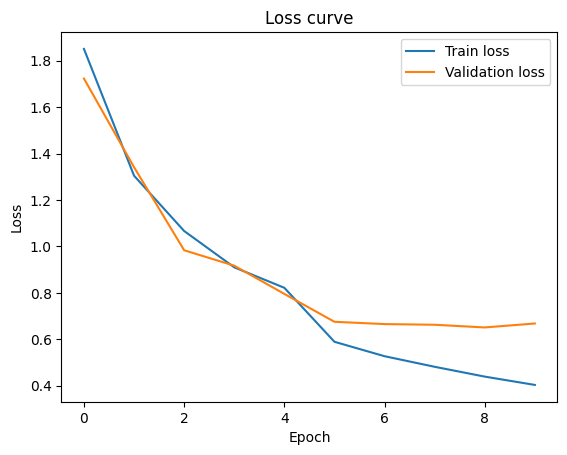

In [ ]:
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model"])

<ipython-input-78-7f9a5e566b90>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth")["model"])


<All keys matched successfully>

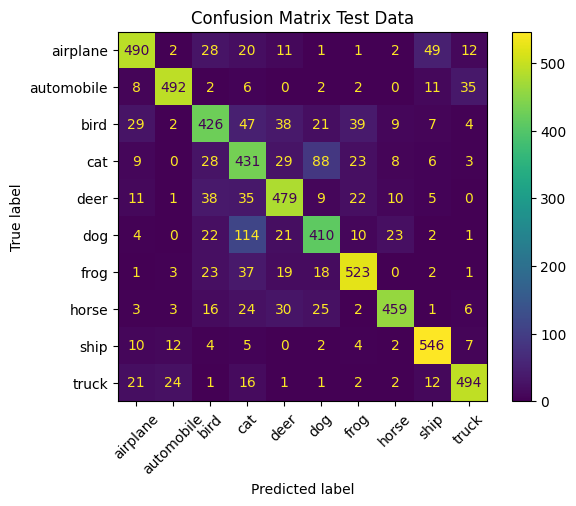




              precision    recall  f1-score   support

    airplane       0.84      0.80      0.82       616
  automobile       0.91      0.88      0.90       558
        bird       0.72      0.68      0.70       622
         cat       0.59      0.69      0.63       625
        deer       0.76      0.79      0.77       610
         dog       0.71      0.68      0.69       607
        frog       0.83      0.83      0.83       627
       horse       0.89      0.81      0.85       569
        ship       0.85      0.92      0.89       592
       truck       0.88      0.86      0.87       574

    accuracy                           0.79      6000
   macro avg       0.80      0.79      0.80      6000
weighted avg       0.80      0.79      0.79      6000



In [ ]:
_, _, y_pred = validate(model, test_loader, criterion, device)
y_test = [labels for _, labels in test_loader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))